# Model Validation and Optimization

in this part, we are going to learn how to use k-fol cross validation to test model performance. as well as how to use validation curves to optimize model parameters. We will also learn how to implement reduction tehniques such as Principal Componen Analysis(PCA).

**Assessing Models with K-fold Cross Validation**
Thus far, we have trained models on a subset of data and then assessed performacne on the test set. This is a good practice because the model performance on data that is used for training is not a good indicator. of its effectiveness as a predictor. It is very easy to increase accuracy on a training dataset by overfitting a model, which result in a poorer performance on test set. 

However, simply training models on data that has been split in this way is not good enough. There is a natural variance in data that causes accuracies to be different depending on splitting the training and test splits. Furthemore, using only one training/test split to compare models can introduce bias toward certain models and lead to overfitting. 

K-Fold cross validation offers a solution to this problem and allow variance to be accounted for by way of an error estimate on each accuracy calculation. 

The workflow of K-fold cross validation :
1, Split data into k folds of near-equal size
2. Test and train k model on different fold combination where model includes k-1 folds of training data and uses the left-out fold as the validation set. 
3. Calculate the model accuracy by taking the mean of the k accuracy values. The standard deviation is also calculated to provide error estimates on the value.

**Caution**
It is standard to set k = 10, but smaller values for k should be considered if you are using big dataset. 

# Using k-fold Cross Validation and Validation Curves in Python with Scikit Learn

In [18]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,seaborn,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-08-14 

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.3
seaborn 0.10.0
sklearn 0.22.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [19]:
df = pd.read_csv('data/hr-analytics/hr_data_processed.csv')

In [20]:
#set up the training data
from sklearn.model_selection import train_test_split
features = ["satisfaction_level", "last_evaluation"]
X,X_test,y,y_test =train_test_split(
        df[features].values,
        df["left"].values,
        test_size=0.15,
        random_state=1
)

In [21]:
"""
    in this point, we have not performed any interesting computiation.
    We just simply prepared a model object, clf, and defined its hyperparameter
    for instance max_depth
"""
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)


In [22]:
from sklearn.model_selection import cross_val_score
np.random.seed(1)
scores =cross_val_score(
        estimator =clf,
        X=X,
        y=y,
        cv =10,
)
print("accuracy = {:.3f} +/- {:3f}".format(
    scores.mean(),
    scores.std(),
))

accuracy = 0.923 +/- 0.005642


Here , we just train 10 variations of our clf model using stratified k-fold validation. Note that scikit-learn cross _val_score does this type of validation by default. we use np.random.seed to set the seed for the random number generator, ensuring reproducibility with respect to any computation that follows on random numbers. In this case, we set the seed to ensure reproducibility of randomly selected samples for each fold in stratified k-fold cross validation. 

In [23]:
print(scores)

[0.92235294 0.91529412 0.92784314 0.92941176 0.9254902  0.92705882
 0.91294118 0.91607843 0.92235294 0.9277865 ]


Using cross_val_score is a convenient way to accomplish k-fold cross validation, but it does not tell us about the accuracies within each class. Since our problem is sensitive to each class accuracy , we will need to manually implement k-fold cross validation so that this information is available to us. In particular, we are interested in accuracy of class 1, which represents the employees who have left. 

In [30]:
#Define k-fold cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
def cross_val_class_score(clf,X,y,cv=10):
    kfold =(
        StratifiedKFold(n_splits=cv)
        .split(X,y)
    )
    class_accuracy =[]
    for k, (train,test) in enumerate(kfold):
        clf.fit(X[train],y[train])
        y_test = y[test]
        y_pred = clf.predict(X[test])
        cmat = confusion_matrix(y_test,y_pred)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print("fold: {:d} accuracy: {:s}".format(
                k+1,
            str(class_acc),
        ))
    return np.array(class_accuracy)

We implement k-fold cross validation manually using model_selection/StratifiedKFold class in scikit-learn. This class takes number of folds as an initialization argument and provides the split method to build randomly samples masks for the data. In this instance, a mask is simply an array containing indexes of items in another array, where the items can then be returned by running code such as data[mask]

In [31]:
#Calculate class accuracies 
np.random.seed(1)
scores = cross_val_class_score(clf,X,y)
print("Accuracy = {} +/- {}".format(
        scores.mean(axis=0),
        scores.std(axis=0),
))

fold: 1 accuracy: [0.98558187 0.72039474]
fold: 2 accuracy: [0.98559671 0.68976898]
fold: 3 accuracy: [0.98971193 0.72937294]
fold: 4 accuracy: [0.98765432 0.74257426]
fold: 5 accuracy: [0.99074074 0.71617162]
fold: 6 accuracy: [0.98971193 0.72607261]
fold: 7 accuracy: [0.98251029 0.68976898]
fold: 8 accuracy: [0.98559671 0.69306931]
fold: 9 accuracy: [0.9845679  0.72277228]
fold: 10 accuracy: [0.98352214 0.74917492]
Accuracy = [0.98651946 0.71791406] +/- [0.00266344 0.0200439 ]


These outputs show the accuracies where the first value corresponds to class 0 and the second corresponds to class 1. Having seen k-fold cross validation in action, We will move on to the topic of validation curves. 

In [32]:
"""
    Calculate validation curves with model_selection.validation_curve 
    to stratify k-fold cross validation to train models for various values of a specified hyperparameter
    
"""
from sklearn.model_selection import validation_curve
clf = DecisionTreeClassifier()
max_depth_range = np.arange(3,20,1)
np.random.seed(1)
train_scores, test_scores = validation_curve(
        estimator =clf,
        X = X,
        y = y,
        param_name ="max_depth",
        param_range = max_depth_range,
    cv = 5,
)

By training this, we have trained a set of decision trees over the range of max_depth values. These values are defined in the max_depth_range = np.arange(3,20,1) line which corresponds to the [3,4,....18,19] array from max_depth =3 up to the max_depth = 20 with step size 1. The validation_curve function will return arrays with cross validation (training and test) scores for a set of models where each set has a different max_depth variable. 

In [36]:
#Visualize the results
def plot_validation_curve(
        train_scores,
        test_scores,
        param_range,
        xlabel=" ",
        log = False,
):
    

    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis = 1)
    test_std = np.std(test_scores, axis=1)
    
    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

(0.89, 0.95)

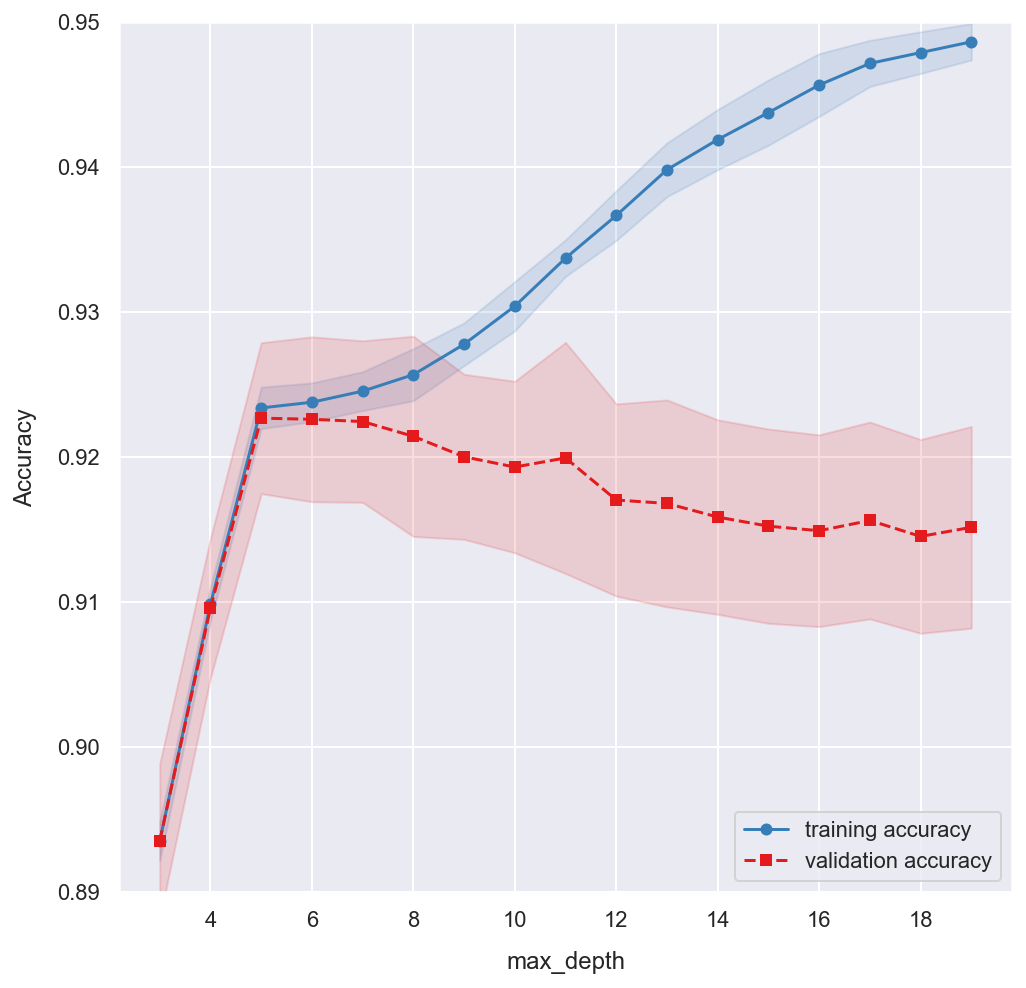

In [37]:
plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel='max_depth',
)
plt.ylim(0.89, 0.95)

Setting the max depth parameter for decision trees controls the balance between underfitting and overfitting. This is reflected in the validation curve, where we can see low accuracies for small maximum depth values(underfitting) since we are not allowing decision tree to create enough branches to capture the patterns in the data. 

For large max depth values to the right of the chart , we can see the opposite happens, as the decision tree here overfit the training data which indicates validation accuracy (red squares) decreases as the maximum depth increases. 

# Dimension Reduction with PCA

Dimension reduction can be as simple as removing unimportant features from training data. However, It is usually not obvious that removing a set of features will boost model performance. Even features that are highly noisy may offer some valuable information that models can learn from. For these reasons, we should know about better methods for reducing data dimensionality 

1. Principal Component Analysis(PCA)
2. Linear Discriminant Analysis(LDA)

PCA is a tecnique to transform the data by projecting it into a new subspaceof orthgonal principal components, where the componenets with the highest eigenvalues encode the most information for the training model.　Then we select a set of principal componenets in place of the original high-dimensional dataset. 

**PCA** could be used to encode information from every pixel in an image. in this case, the original feature space would have dimension equal to the number of pixels in the image. This high-dimensional space could then be reduced with PCA, where the majority of useful informationfor training predictive models might be reduced to just a few dimension. 

In [38]:
#I just directly doing df.columns because i have already load the data in this notebook
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

In order to determine which features are good candidates for reducing with PCA, you want to calculate how important each of them is for making prediction. Once you know this information, you can select those that are least important for PCA and leave the most important feature intact. We will use a decision tree classifier for explore it. 

In [39]:
features = [
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'work_accident',
    'promotion_last_5years', 'department_IT', 'department_RandD',
    'department_accounting', 'department_hr', 'department_management',
    'department_marketing', 'department_product_mng', 'department_sales',
    'department_support', 'department_technical', 'salary_high',
    'salary_low', 'salary_medium'
]

x = df[features].values
y =df.left.values
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

we choose max_depth=10 because decision trees tend to require more depth to avoid underfitting due to implementing many features. Now, let's check the importance of each feature for making prediction by using feature_importance attribute of clf


Text(0.5, 0, 'Feature importance')

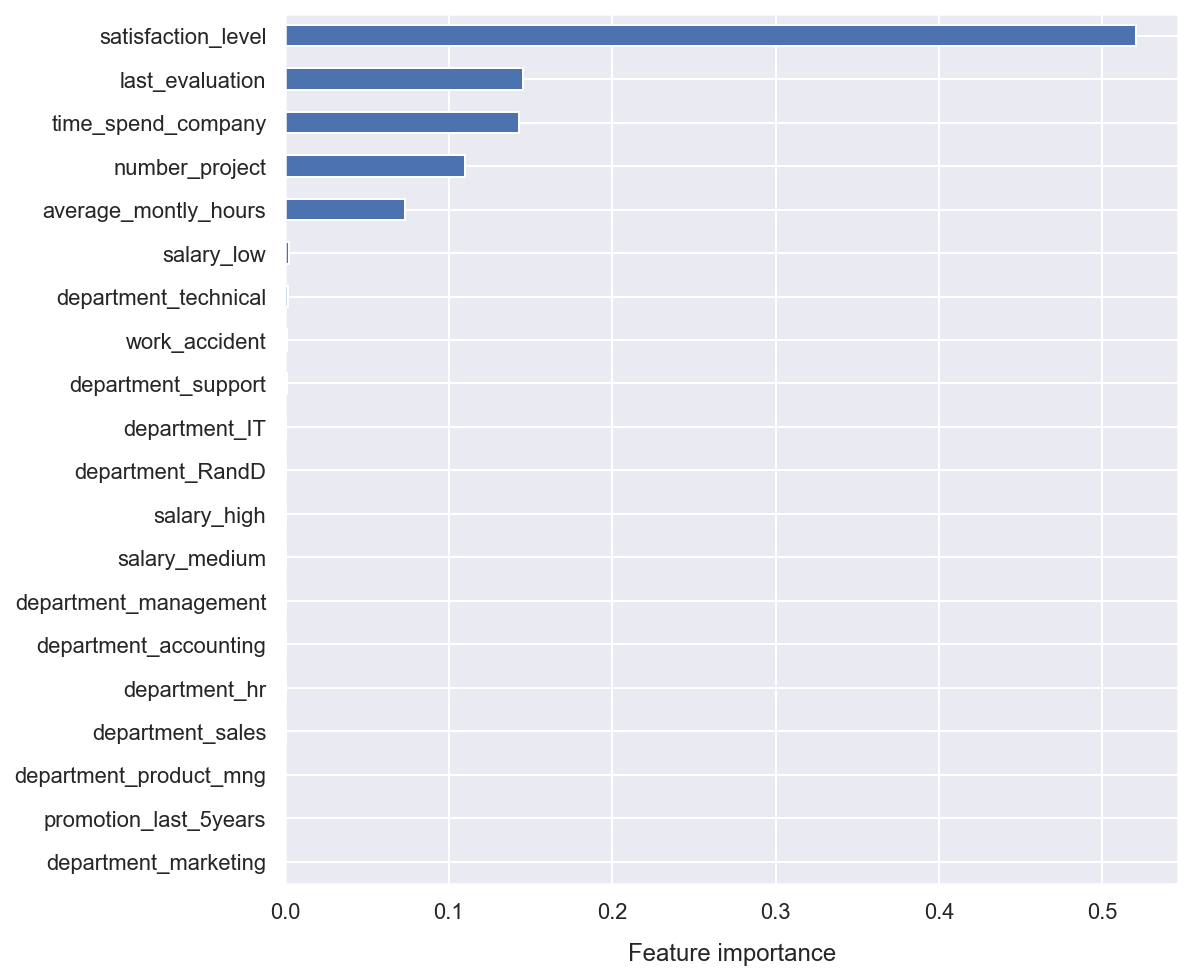

In [40]:
(
    pd.Series(
    clf.feature_importances_,
    name ="Feature importance",
    index = df[features].columns,
    )
    .sort_values()
    .plot.barh()

)
plt.xlabel("Feature importance")

We can see there are a handful of features that are having significant importance when it comes to making prediction, and the rest appear to have near-zero importance. 

Keep in mind that this chart does not represent the true feature importance, but simply that of the quick and dirty decision tree model, clf. In other words, the features with near-zero importance in the chart may be important for other models. In any case, the information here is sufficient for us to make a selection on which features to reduce with PCA.

In [43]:
#set aside the 5 most important features 
importances = list(

        pd.Series(
            clf.feature_importances_,
            index=df[features].columns,
        )
    .sort_values(ascending=False).index
)

low_importance_features = importances[5:]
high_importance_features = importances[:5]

np.array(low_importance_features)



array(['salary_low', 'department_technical', 'work_accident',
       'department_support', 'department_IT', 'department_RandD',
       'salary_high', 'salary_medium', 'department_management',
       'department_accounting', 'department_hr', 'department_sales',
       'department_product_mng', 'promotion_last_5years',
       'department_marketing'], dtype='<U22')

In [44]:
#print the high importances features
np.array(high_importance_features)

array(['satisfaction_level', 'last_evaluation', 'time_spend_company',
       'number_project', 'average_montly_hours'], dtype='<U20')

In [47]:
# Having identified the features to use for dimensionality reduction
from sklearn.decomposition import PCA
pca_features = [
    
    'salary_low', 'department_technical', 'department_support',
    'work_accident', 'salary_medium', 'department_IT',
    'department_RandD', 'salary_high', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
    
]

X_reduce = df[pca_features]
pca = PCA(n_components=3)
pca.fit(X_reduce)
X_pca = pca.transform(X_reduce)

We used n_components = 3 , indicating that we want to keep the first three components returned by PCA algorithms, finally, we fit our instatiated PCA class and then transform the same dataset. 


In [49]:
X_pca.shape

(14999, 3)

This result implies that we have three arrays of length 14,999 corresponding to the three principal components for each record in the dataset. 


In [50]:
df['first_principle_component'] = X_pca.T[0]
df['second_principle_component'] = X_pca.T[1]
df['third_principle_component'] = X_pca.T[2]

In [52]:
df.to_csv(
    'data/hr-analytics/hr_data_processed_pca.csv',
    index=False,
)

In [53]:
#Save the fit PCA class
import joblib
joblib.dump(pca,'hr-analytics-pca.pkl')

['hr-analytics-pca.pkl']

# Model Training for Production


In [54]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium', 'first_principle_component',
       'second_principle_component', 'third_principle_component'],
      dtype='object')

In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,6.128335e-01,0.248631,0.090000,0.440000,0.640000,0.820000,1.000000
last_evaluation,14999.0,7.161017e-01,0.171169,0.360000,0.560000,0.720000,0.870000,1.000000
number_project,14999.0,3.803054e+00,1.232592,2.000000,3.000000,4.000000,5.000000,7.000000
average_montly_hours,14999.0,2.009925e+02,49.492423,96.000000,156.000000,200.000000,244.000000,310.000000
time_spend_company,14999.0,3.489166e+00,1.452451,2.000000,3.000000,3.000000,4.000000,10.000000
work_accident,14999.0,1.446096e-01,0.351719,0.000000,0.000000,0.000000,0.000000,1.000000
left,14999.0,2.380825e-01,0.425924,0.000000,0.000000,0.000000,0.000000,1.000000
promotion_last_5years,14999.0,2.126808e-02,0.144281,0.000000,0.000000,0.000000,0.000000,1.000000
department_IT,14999.0,8.180545e-02,0.274077,0.000000,0.000000,0.000000,0.000000,1.000000
department_RandD,14999.0,5.247016e-02,0.222981,0.000000,0.000000,0.000000,0.000000,1.000000


Summary of the features:
1. satisfaction_level  & last_evaluation : numerical and span continuously from 0 to 1
2. number_project & time_spend_company : Boolean fields
3. work_accident &promotionlast_5years : Boolean fields
4. department_IT & salary_medium : one-hot encoded categorical features

In [57]:
#select features to use our model as the top five features from the PCA

from sklearn.model_selection import train_test_split
features =[
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X, X_test,y,y_test = train_test_split(
    df[features].values,
    df["left"].values,
    test_size = 0.15,
    random_state =1

)

In [64]:
#Calculate validation curve for a decision tree with max depth ranging from 2 to 52

from sklearn.tree import DecisionTreeClassifier
np.random.seed(1)
clf = DecisionTreeClassifier()
max_depth_range = np.arange(2,53,2)
print("Training {} models ...".format(len(max_depth_range)))
train_scores,test_scores = validation_curve(

        estimator =clf,
        X =X,
        y=y,
         param_name='max_depth',
        param_range=max_depth_range,
        cv=10,
)



Training 26 models ...


we just run 25 sets of k-fold cross validation one for each value of the max_depth hyperparameter in our defined range. By setting cv = 10, we produce 10 estimates of the accuracy for each model from the mean and standard deviation are calculated in order to plot in the validation curve. In total, we train 250 models over various maximum depths and subsets of the data. 

(0.95, 1.0)

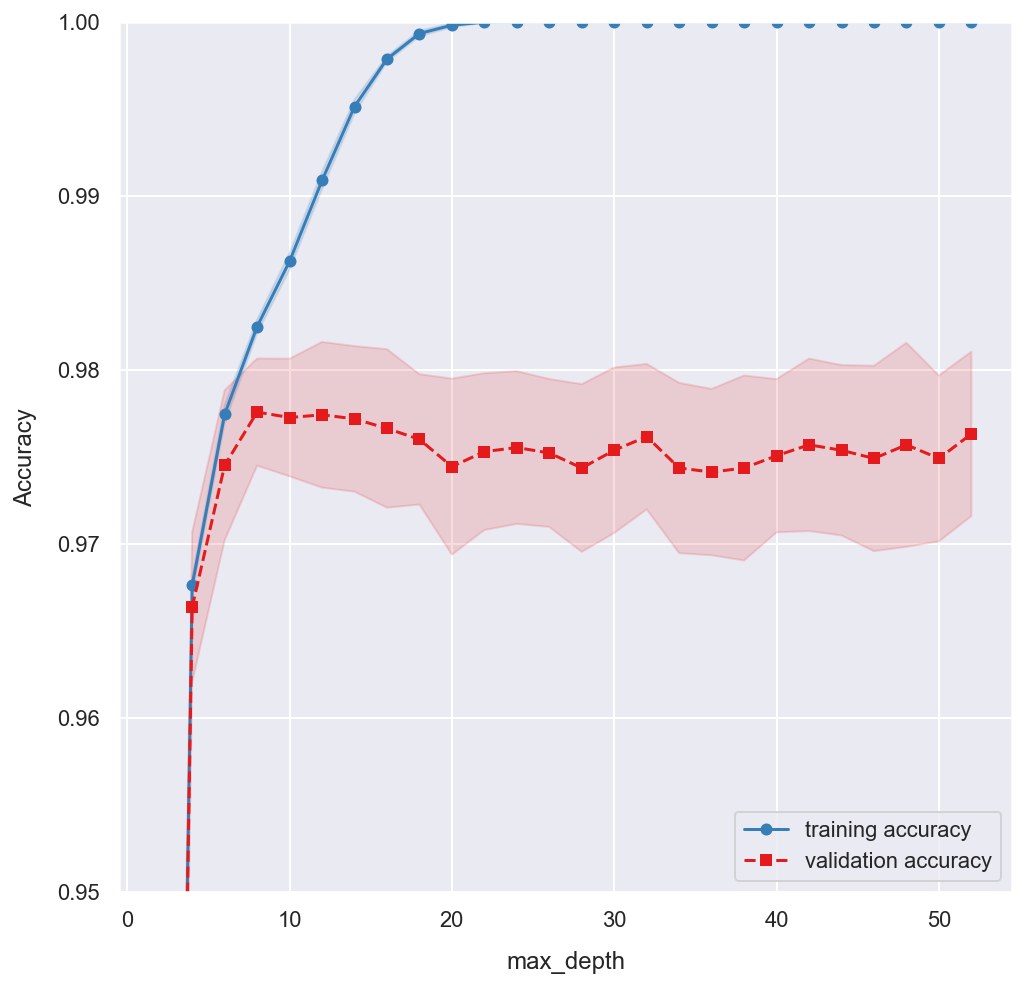

In [65]:
plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel ="max_depth",
)
plt.ylim(0.95, 1.0)

Looking at this validation curve, we can see the accuracy of the training set (blue circles) quickly approach 100% hitting this mark around max_depth =20. The validation set(red squares) reaches a maximum accuracy around max_depth=8, before dropping slighly as max_depth increase beyond this point. This happens because the modelsin this range

In [67]:
# Check themk-fold cross validation accuracy for each class with cross_val_class_score
clf = DecisionTreeClassifier(max_depth=8)
np.random.seed(1)
scores = cross_val_class_score(clf,X,y)
print("accuracy = {} +/- {} ".format(
        scores.mean(axis=0),
        scores.std(axis=0)
) )

fold: 1 accuracy: [0.9938208  0.91118421]
fold: 2 accuracy: [0.99588477 0.91089109]
fold: 3 accuracy: [0.99897119 0.91749175]
fold: 4 accuracy: [0.99588477 0.95379538]
fold: 5 accuracy: [0.99279835 0.91419142]
fold: 6 accuracy: [0.99588477 0.92079208]
fold: 7 accuracy: [0.99485597 0.92409241]
fold: 8 accuracy: [0.99382716 0.9339934 ]
fold: 9 accuracy: [0.99074074 0.91419142]
fold: 10 accuracy: [0.99176107 0.94059406]
accuracy = [0.99444296 0.92412172] +/- [0.00226455 0.01357943] 


As can be seen, this model is performing much better than previous models for clas 1, with an average accuracy of 92.4 +/- 1.4%. 

Text(0, 0.5, 'Accuracy')

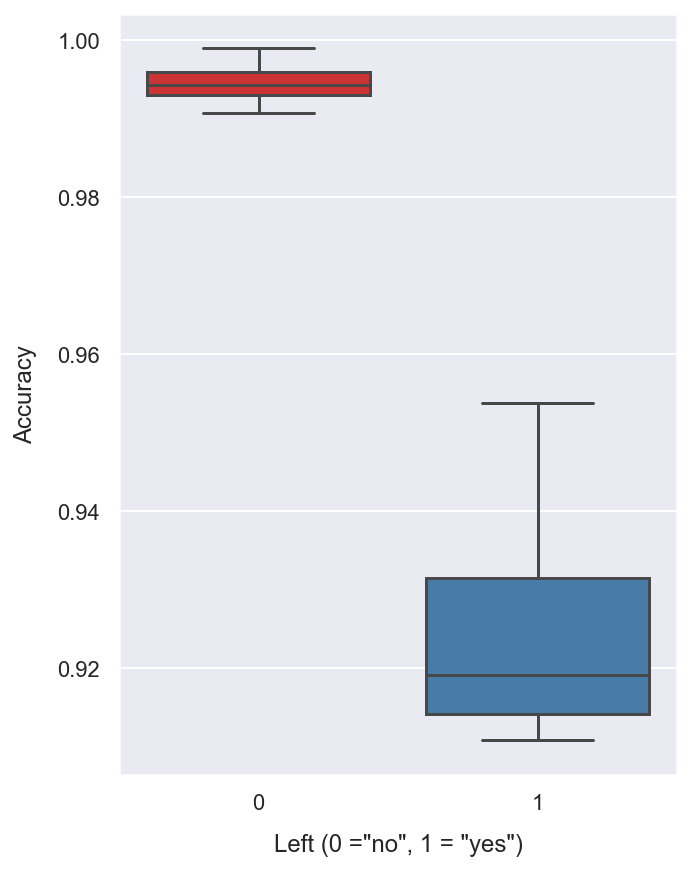

In [69]:
fig = plt.figure(figsize = (5,7))
sns.boxplot(
    data = pd.DataFrame(scores, columns =[0,1]),
    palette = sns.color_palette("Set1")
)

plt.xlabel('Left (0 ="no", 1 = "yes")')
plt.ylabel("Accuracy")

At this point, having finished the hyperparameter optimization, we should check how well the model performs on the test set. This result will give more confidence that i will perform well when making predictions in production. 

In [70]:
#Train the model
from sklearn.metrics import confusion_matrix
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X,y)
y_pred = clf.predict(X_test)
cmat = confusion_matrix(y_test,y_pred)
cmat.diagonal() /cmat.sum(axis=1) * 100


array([99.23976608, 93.88888889])

These test accuracies should fall within or very close to the range of the k-fold cross validation accuracies we calculated previously. For class 0, we can see 99.2% which falls within the k-fold range of 99.2%-99.6% and for class 1, we can see 93.9% which falls just above the k-fol range 0f 91%-93.8%. These are good results, which give us confidence that our model will perform well in production. 

We have nearly creating our production model. Having selected the best hyperparameters and tested the accuracy, now train a new model on the full dataset

In [72]:
features = [
    'satisfaction_level', 'last_evaluation',
    'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X = df[features].values
y = df["left"].values
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [73]:
# Dump the model to binary file by using joblib module
import joblib
joblib.dump(clf, 'hr-analytics-pca-tree.pkl')

['hr-analytics-pca-tree.pkl']

In [75]:
!ls .


LICENSE                   Untitled6.ipynb           data
README.md                 assets                    figures
Untitled.ipynb            chapter-01                hr-analytics-pca-tree.pkl
Untitled1.ipynb           chapter-02                hr-analytics-pca.pkl
Untitled2.ipynb           chapter-03                requirements.txt
Untitled3.ipynb           chapter-04                tests
Untitled4.ipynb           chapter-05
Untitled5.ipynb           chapter-06


In [76]:
# use the model to make predictions
clf = joblib.load('hr-analytics-pca-tree.pkl')
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [77]:
"""
    Select a record from the training data and filter it on the original 
    feature columns, and pretend this is the employee profile for Bob. 
    
"""

pca_features = [
    'salary_low', 'department_technical', 'work_accident',
    'department_support', 'department_IT', 'department_RandD',
    'salary_high', 'salary_medium', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

non_pca_features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours'

]

bob = df.iloc[8483][pca_features + non_pca_features ]
bob

salary_low                  1.00
department_technical        0.00
work_accident               0.00
department_support          0.00
department_IT               0.00
department_RandD            0.00
salary_high                 0.00
salary_medium               0.00
department_management       0.00
department_accounting       0.00
department_hr               0.00
department_sales            1.00
department_product_mng      0.00
promotion_last_5years       0.00
department_marketing        0.00
satisfaction_level          0.77
last_evaluation             0.68
time_spend_company          2.00
number_project              3.00
average_montly_hours      225.00
Name: 8483, dtype: float64

In general, a prediction sample would need to be prepared in exactly the same way that the training data was, which includes the same method of data cleaning such as filling missing values and one-hot encoding categorical variables. In this case (for Bob), this preprocessing has already been done. However, at this point, assume that PCA transformations have not beend done yet. This is a necessary step in order to produce the proper input  that our model requires. 

In [79]:
#Load the PCA transformation
pca = joblib.load('hr-analytics-pca.pkl')
pca_feature_values = pca.transform([bob[pca_features]])[0]
pca_feature_values

array([-0.67733089,  0.75837169, -0.10493685])

In [80]:
#Create prediction vector for Bob that can be input into prediction method
X_bob = np.concatenate((bob[non_pca_features].values,
                       pca_feature_values))
X_bob

array([ 7.70000000e-01,  6.80000000e-01,  2.00000000e+00,  3.00000000e+00,
        2.25000000e+02, -6.77330887e-01,  7.58371688e-01, -1.04936853e-01])

In [81]:
#Check for predicting that Bob will leave the company
clf.predict([X_bob])

array([0])

This means that Bob will not leave the company since he was assigned to class 0 and our model has assigned 98% probability to Bob remaining at the company.

In [82]:
# Check the probability 
clf.predict_proba([X_bob])

array([[0.98462639, 0.01537361]])

# Hyperparameter Tuning and Model Selection/Exercises

In [83]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,seaborn,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-08-14 

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
matplotlib 3.1.3
seaborn 0.10.0
sklearn 0.22.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [84]:
df = pd.read_csv('data/hr-analytics/hr_data_processed_pca.csv')
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium', 'first_principle_component',
       'second_principle_component', 'third_principle_component'],
      dtype='object')

In [85]:
from sklearn.model_selection import train_test_split
features =[
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]

X, X_test, y, y_test = train_test_split(
        df[features].values,
        df["left"].values,
        test_size =0.15,
        random_state =1
)

In [88]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1)
clf = RandomForestClassifier(n_estimators = 50)
max_depth_range = np.arange(2,52,2)
print("Training {} models" .format(len(max_depth_range)))
train_scores,test_scores =validation_curve(
        estimator= clf,
        X=X,
        y=y,
        param_name = "max_depth",
        param_range = max_depth_range,
        cv = 5
)

Training 25 models


(0.97, 1.0)

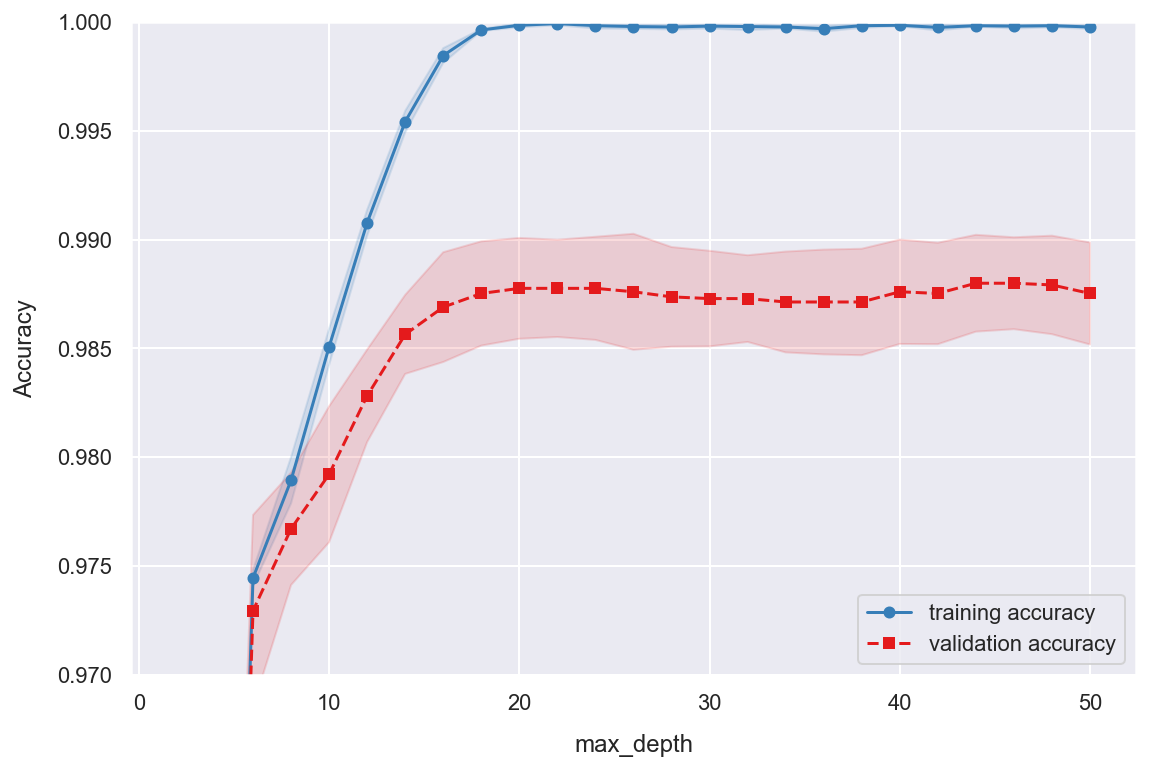

In [89]:
plot_validation_curve(

    train_scores,
    test_scores,
    max_depth_range,
    xlabel = "max_depth"
)
plt.ylim(0.97, 1.0)

In some ways, this validation curve is very similar to the chart to we saw for the decision tree earlier, which was trained on the same features as Random Forest. In particular, we can see the training set(blue circles) quickly approach an accuracy of 100% while the validation set(red square) is limited to a lower maximum accuracy. 

Unlike the validation curve earlier, However, the validation set here appears to converge to the maximum accuracy as max_depth is increased. This is not the behaviour we saw earlier for the decision tree, where the validation set accuracy reach a maximum of around max_depth=8 and then dropped off slightly for higher values of max_depth

In [90]:
#Calculate the k-fold cross validation
clf = RandomForestClassifier(n_estimators =50, max_depth=25)
np.random.seed(1)
scores = cross_val_class_score(clf,X,y)
print("accuracy = {} +/- {}".format(
        scores.mean(axis=0),
        scores.std(axis=0)
))

fold: 1 accuracy: [0.99794027 0.94407895]
fold: 2 accuracy: [0.99897119 0.96039604]
fold: 3 accuracy: [0.99897119 0.96039604]
fold: 4 accuracy: [0.99691358 0.98349835]
fold: 5 accuracy: [0.99897119 0.9669967 ]
fold: 6 accuracy: [0.99794239 0.95379538]
fold: 7 accuracy: [0.99794239 0.95709571]
fold: 8 accuracy: [0.99794239 0.95379538]
fold: 9 accuracy: [0.99588477 0.94059406]
fold: 10 accuracy: [0.99485067 0.97689769]
accuracy = [0.997633   0.95975443] +/- [0.00130649 0.0126565 ]


Comparing to the decision tree result from previous exercise, we can see a significant improvement in the accuracy of each class, with class 0 rising from 99.4% to 99.8% and class 1 rising from 92.4% to 95.9%

In [91]:
#Evaluate the performance
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(n_estimators=50, max_depth=25)
clf.fit(X,y)
y_pred = clf.predict(X_test)
cmat = confusion_matrix(y_test,y_pred)
cmat.diagonal() / cmat.sum(axis=1) * 100


array([99.70760234, 97.03703704])

In [92]:
#train the model
features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X = df[features].values
y = df["left"].values
clf = RandomForestClassifier(n_estimators = 50, max_depth= 25)
clf.fit(X,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
#save the model to disk 
import joblib
joblib.dump(clf, 'hr-analytics-pca-forest.pkl')

['hr-analytics-pca-forest.pkl']

In [95]:
#reload the model
clf = joblib.load('hr-analytics-pca-forest.pkl')
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
# Check the model performance for an imaginary employee Alice

alice = df.iloc[573][features]
alice

satisfaction_level              0.360000
last_evaluation                 0.470000
time_spend_company              3.000000
number_project                  2.000000
average_montly_hours          148.000000
first_principle_component       0.742801
second_principle_component     -0.514568
third_principle_component      -0.677421
Name: 573, dtype: float64

In [98]:
#predict the class label for Alice
clf.predict([alice.values])

array([1])

In [99]:
#Calculate probability
clf.predict_proba([alice.values])

array([[0., 1.]])

In order to improve the chance of the company being able to retain Alice as an employee, they could try to reduce the amount of time she needs to spend at work. Using our model, we can test the effect that might have on her likelihood of leaving

In [100]:
# Reevaluate prediction probability

alice.average_montly_hours = 100
alice.time_spend_company = 2
clf.predict_proba([alice.values])

array([[0.84, 0.16]])

In [101]:
#predict new class lable 
clf.predict([alice.values])


array([0])

This result suggests that by reducing the number of monthly hours at work to 100 and the amount of time spent at the company to level 2 , there is an 84% chance that Alice will not leave the company. 